# Tracking AfD polling surveys
> Polling surveys of the AfD with data aggregated daily from different opinion research centers

- comments: true
- author: Caglar Cakan
- categories: [data]
- permalink: /afd-data/
- image: images/icon_afd.png
- license: Creative Commons

The data for this script is pulled from https://www.wahlrecht.de/umfragen. Below the code, you can find the output figure.

In [1]:
#hide
#plt.style.use("light")

In [2]:
#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 29.07.20 01:23:06


Getting data from Allensbach ...


	Last value: 9.0%
	Last datapoint: 2020-07-22
Getting data from Kantar ...


	Last value: 11.0%
	Last datapoint: 2020-07-26
Getting data from ForsaForsch’gr. Wahlen ...


	Last value: 9.0%
	Last datapoint: 2020-07-25
Getting data from GMS ...


	Last value: 9.0%
	Last datapoint: 2020-07-10
Getting data from Infratest ...


	Last value: 10.0%
	Last datapoint: 2020-07-27
Getting data from dimap ...


	Last value: 11.0%
	Last datapoint: 2020-07-23
Getting data from Yougov ...


	Last value: 11.0%
	Last datapoint: 2020-06-26


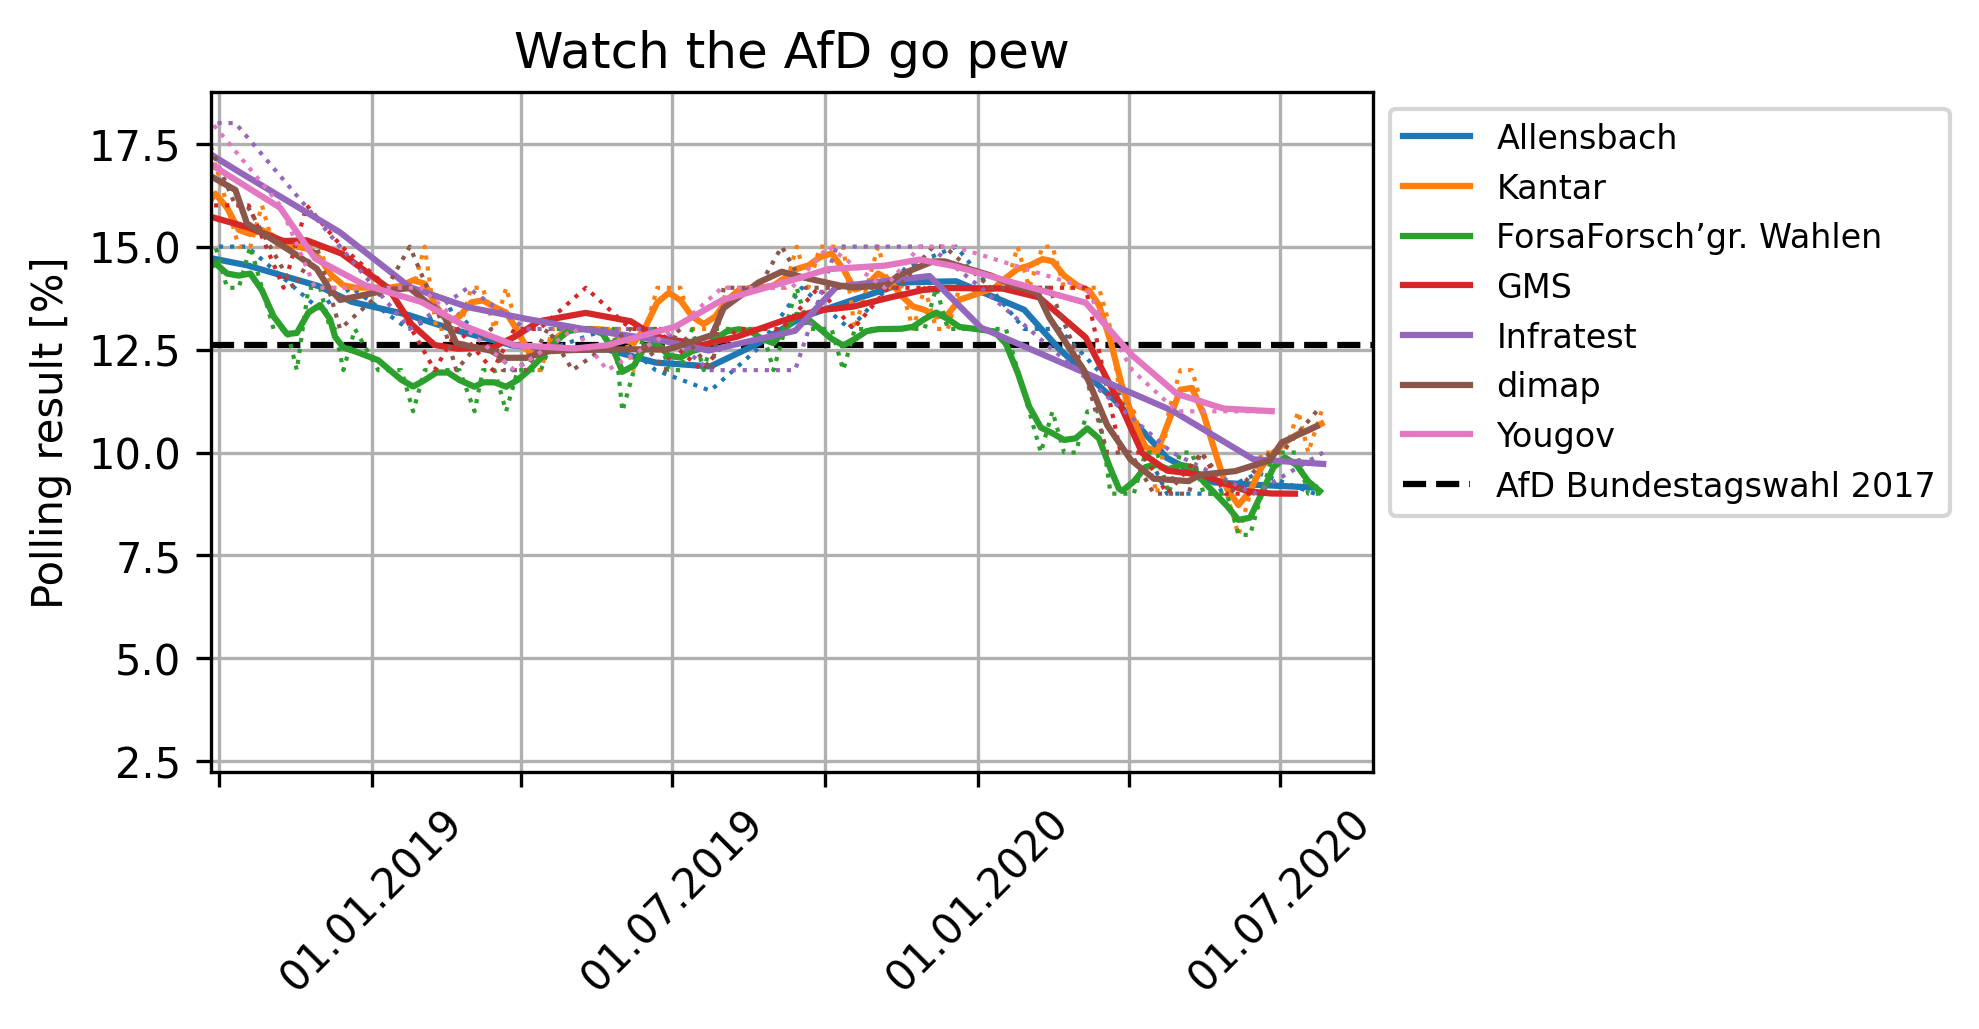

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d

table_urls = ["https://www.wahlrecht.de/umfragen/allensbach.htm",
              "https://www.wahlrecht.de/umfragen/emnid.htm",
              "https://www.wahlrecht.de/umfragen/forsa.htm",
              "https://www.wahlrecht.de/umfragen/politbarometer.htm",
              "https://www.wahlrecht.de/umfragen/gms.htm",
              "https://www.wahlrecht.de/umfragen/dimap.htm",
              "https://www.wahlrecht.de/umfragen/yougov.htm",
              #"https://www.wahlrecht.de/umfragen/insa.htm" # broken data
             ]
names = ["Allensbach", "Kantar", "Forsa" "Forsch’gr. Wahlen", "GMS", "Infratest", "dimap", "Yougov", "INSA"]

# get the election results
election_results = pd.read_html("https://www.wahlrecht.de/umfragen/")[1]
election_results["percent"] = election_results["Bundes-tagswahl"].iloc[1:].str.replace(',', '.').str.rstrip('%').astype('float')
election_results = election_results.set_index("Institut")

# get polling results

party_to_watch = "AfD"

plt.figure(figsize=(5, 3), dpi=300)
for i, table_url in enumerate(table_urls):
    print(f"Getting data from {names[i]} ...")
    # magic function to get tables from a website, <3
    df = pd.read_html(table_url)[1]
    # cut last 4 lines which are trash
    df = df.iloc[:-4]
    df = df.replace("–")
    # convert to datetime
    df["Datetime"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y") if "Datum" in df.columns else pd.to_datetime(df["Unnamed: 0"], format="%d.%m.%Y")
    # get rid of trash
    df = df.drop(columns=["Unnamed: 0", "Unnamed: 1"])
    # list of parties
    parties = df.columns[:6]

    for party in parties:
        df[party] = df[party].str.replace(',', '.').str.rstrip('%').astype('float')
    
    smoothed = gaussian_filter1d(df[party_to_watch], 1)
    
    print(f"\tLast value: {df[party_to_watch].iloc[0]}%")
    print(f"\tLast datapoint: {df['Datetime'].iloc[0].date()}")
    
    plt.plot(df["Datetime"], smoothed,label=names[i], c="C" + str(i))
    plt.plot(df["Datetime"], df[party_to_watch], ls=':', lw=1, c="C" + str(i))
    
from_weeks = 24 * 4
to_weeks = 4
# add line that marks results from last elections
plt.hlines(election_results.loc[party_to_watch, "percent"], datetime.datetime.now() - datetime.timedelta(weeks=from_weeks), datetime.datetime.now() + datetime.timedelta(weeks=to_weeks), color='k', ls='--', label=f'{party_to_watch} Bundestagswahl 2017')

# adjust plot settings
plt.title(f"Watch the {party_to_watch} go pew")
plt.xlim([datetime.datetime.now() - datetime.timedelta(weeks=from_weeks), datetime.datetime.now() + datetime.timedelta(weeks=to_weeks)])
myFmt = mdates.DateFormatter("%d.%m.%Y")
plt.gca().xaxis.set_major_formatter(myFmt)    
plt.grid()
plt.legend(fontsize=8, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Polling result [%]")
plt.setp(plt.gca().get_xticklabels()[::2], visible=False)
plt.xticks(rotation=45)
plt.savefig("../images/icon_afd.png");